# Load Library


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# to split the datasets
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

!pip install feature_engine
!pip install category_encoders

     |████████████████████████████████| 153kB 6.7MB/s 
     |████████████████████████████████| 9.5MB 8.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 81kB 5.3MB/s 


# Filter Methods

In [ ]:
# load dataset

# (feel free to write some code to explore the dataset and become
# familiar with it ahead of this demo)

data = pd.read_csv('datasets/dataset_1.csv')
data.shape

(50000, 301)

## Basic Filter

In [ ]:
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures

# CONSTANT FEATURES
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1), # drop the target
    data['target'], # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

sel = DropConstantFeatures(tol=1, variables=None, missing_values='raise')

sel.fit(X_train)

# list of constant features
sel.features_to_drop_

# number of constant features
len(sel.features_to_drop_)

# let's explore 1 of the constant feature values
X_train[sel.features_to_drop_[0]].unique()

# remove constant features from the data
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((35000, 266), (15000, 266))

In [ ]:
# QUASI CONSTANT FEATURE

from feature_engine.selection import DropConstantFeatures

# CONSTANT FEATURES
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1), # drop the target
    data['target'], # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

sel = DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')

sel.fit(X_train)

# list of constant features
sel.features_to_drop_

# number of constant features
len(sel.features_to_drop_)

# let's explore 1 of the constant feature values
X_train[sel.features_to_drop_[0]].unique()

# remove constant features from the data
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((35000, 158), (15000, 158))

In [ ]:
# REMOVE DUPLICATED FEATURES
# set up the selector
sel = DropDuplicateFeatures(variables=None, missing_values='raise')

# find the duplicate features, this might take a while
sel.fit(X_train)

# these are the pairs of duplicated features
# each set are duplicates
sel.duplicated_feature_sets_

# these are the features that will be dropped
# 1 from each of the pairs above
sel.features_to_drop_

# let's explore our list of duplicated features
len(sel.features_to_drop_)

# remove the duplicated features
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((35000, 152), (15000, 152))

## Correlation

The DropCorrelatedFeatures class from Feature-engine does a similar job to the brute force approach that we described earlier.

The SmartCorrelationSelection allows us to select a feature from each correlated group based on model performance, number of missing values, cardinality or variance.

In [ ]:
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
# load dataset

# (feel free to write some code to explore the dataset and become
# familiar with it ahead of this demo)

data = pd.read_csv('datasets/dataset_2.csv')
data.shape

(50000, 109)

In [ ]:
# Brute force approach
# set up the selector

sel = DropCorrelatedFeatures(
    threshold=0.8,
    method='pearson',
    missing_values='ignore'
)


# find correlated features
sel.fit(X_train)

# each set contains a group of correlated features
sel.correlated_feature_sets_

# drop correlated features
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((35000, 78), (15000, 78))

In [ ]:
# Smart correlation selection by model performance

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

# random forest
rf = RandomForestClassifier(
    n_estimators=10,
    random_state=20,
    n_jobs=4,
)

# correlation selector
sel = SmartCorrelatedSelection(
    variables=None, # if none, selector examines all numerical variables
    method="pearson",
    threshold=0.8,
    missing_values="raise",
    selection_method="model_performance", # selection method can also by "variance"
    estimator=rf,
    scoring="roc_auc",
    cv=3,
)

# this may take a while, because we are training
# a random forest per correlation group
sel.fit(X_train, y_train)

# groups of correlated features
sel.correlated_feature_sets_

[{'var_3', 'var_80'},
 {'var_28', 'var_5', 'var_75'},
 {'var_11', 'var_33'},
 {'var_13', 'var_17'},
 {'var_15', 'var_57'},
 {'var_18', 'var_43'},
 {'var_19', 'var_29'},
 {'var_21', 'var_70', 'var_88'},
 {'var_22', 'var_24', 'var_32', 'var_39', 'var_42', 'var_76'},
 {'var_102', 'var_23'},
 {'var_26', 'var_59'},
 {'var_108', 'var_30'},
 {'var_35', 'var_87'},
 {'var_101', 'var_105', 'var_40', 'var_74', 'var_85'},
 {'var_46', 'var_94'},
 {'var_50', 'var_72'},
 {'var_52', 'var_66'},
 {'var_109', 'var_56'},
 {'var_104', 'var_60'},
 {'var_63', 'var_64', 'var_84', 'var_97'},
 {'var_106', 'var_77'},
 {'var_90', 'var_95'},
 {'var_100', 'var_98'}]

In [ ]:
# lets examine the performace of a random forest based on
# each feature from the second group, to understand
# what the transformer is doing

# select second group of correlated features
group = sel.correlated_feature_sets_[1]

# build random forest with cross validation for
# each feature

for f in group:
    
    model = cross_validate(
        rf,
        X_train[f].to_frame(),
        y_train,
        cv=3,
        return_estimator=False,
        scoring='roc_auc',
    )

    print(f, model["test_score"].mean())

var_75 0.5013582851822869
var_5 0.4997774987558589
var_28 0.5066241880281172


## Filter Statistics

### Mutual Information

Text(0, 0.5, 'Mutual Information')

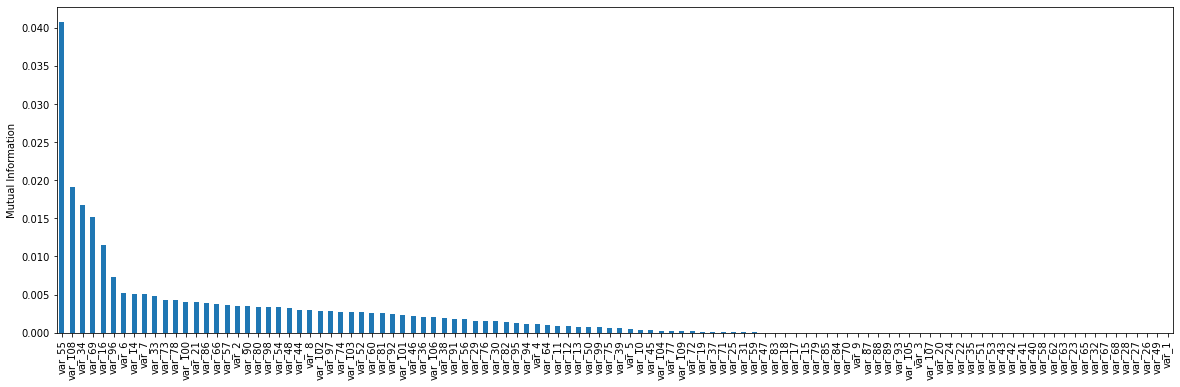

In [ ]:
# to obtain the mutual information values
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile

# CLASSIFICATION
# load dataset

# (feel free to write some code to explore the dataset and become
# familiar with it ahead of this demo)

data = pd.read_csv('datasets/dataset_2.csv')
data.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

# calculate the mutual information between the variables and the target

# the smaller the value of the mi, the less information we can infer from
# the feature about the target

mi = mutual_info_classif(X_train, y_train)
mi

# 1) let's capture the above array in a pandas series
# 2)add the variable names in the index
# 3) sort the features based on their mutual information value
# 4) and make a var plot

mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [ ]:
# here we will select the top 10 features
# based on their mutual information value

# select features
sel_ = SelectKBest(mutual_info_classif, k=10).fit(X_train, y_train)

# display features
X_train.columns[sel_.get_support()]

# to remove the rest of the features:
X_train = sel_.transform(X_train)
X_test = sel_.transform(X_test)

In [ ]:
# REGRESSION
# to obtain the mutual information values
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

data = pd.read_csv('datasets/houseprice.csv')
data.shape

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

## fill missing values

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

data.shape

(1460, 38)

array([[7.000e+00, 1.057e+03, 2.034e+03, 2.000e+00],
       [6.000e+00, 1.291e+03, 1.291e+03, 2.000e+00],
       [5.000e+00, 8.580e+02, 8.580e+02, 0.000e+00],
       ...,
       [6.000e+00, 0.000e+00, 1.902e+03, 2.000e+00],
       [7.000e+00, 1.374e+03, 1.557e+03, 2.000e+00],
       [7.000e+00, 1.195e+03, 1.839e+03, 2.000e+00]])

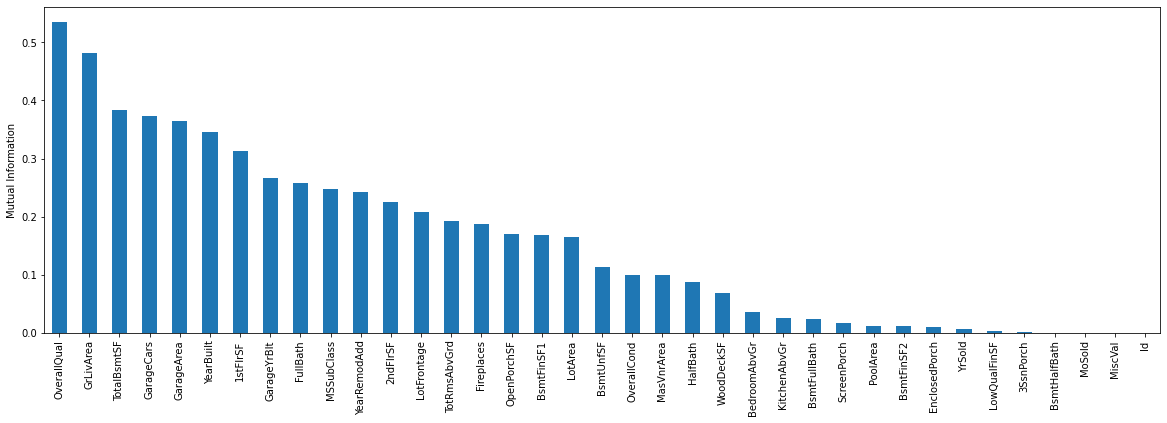

In [ ]:
# determine the mutual information
mi = mutual_info_regression(X_train, y_train)

# and make a bar  plot
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20,6))
plt.ylabel('Mutual Information')

# Select the features in the top percentile
sel_ = SelectPercentile(mutual_info_regression, percentile=10).fit(X_train, y_train)

# display the features
X_train.columns[sel_.get_support()]

# to remove the rest of the features:

X_train = sel_.transform(X_train)
X_test = sel_.transform(X_test)

X_train

### Chi-square (Fisher-Score)

In [ ]:
# to determine the chi2 value
from sklearn.feature_selection import chi2

# to select the features
from sklearn.feature_selection import SelectKBest

data = pd.read_csv('datasets/titanic.csv')
data.shape

# the categorical variables in the titanic are pclass, sex and embarked

# first I will encode the labels of the categories into numbers

# for Sex / Gender
data['sex'] = np.where(data['sex'] == 'male', 1, 0)

# for Embarked
ordinal_label = {k: i for i, k in enumerate(data['embarked'].unique(), 0)}
data['embarked'] = data['embarked'].map(ordinal_label)

# pclass is already ordinal

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data[['pclass', 'sex', 'embarked']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 3), (393, 3))

In [ ]:
# calculate the chi2 p_value between each of the variables
# and the target

# chi2 returns 2 arrays, one contains the F-Scores which are then
# evaluated against the chi2 distribution to obtain the pvalue.
# The pvalues are in the second array

f_score = chi2(X_train.fillna(0), y_train)

# the 2 arrays of values
f_score

# 1) let's capture the p_values (in the second array, remember python indexes at 0) in a pandas Series
# 2) add the variable names in the index
# 3) order the variables based on their fscore

pvalues = pd.Series(f_score[1])
pvalues.index = X_train.columns
pvalues.sort_values(ascending=True)

sel_ = SelectKBest(chi2, k=1).fit(X_train, y_train)

# display features
X_train.columns[sel_.get_support()]

# to remove the rest of the features:

X_train = sel_.transform(X_train)
X_test = sel_.transform(X_test)

### ANOVA (Univariate)

In [ ]:
# to determine the p-values with anova
from sklearn.feature_selection import f_classif, f_regression

# to select features
from sklearn.feature_selection import SelectKBest, SelectPercentile

# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

data = pd.read_csv('datasets/houseprice.csv')
data.shape

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

## fill missing values

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

data.shape

(1460, 38)

(1022, 4)

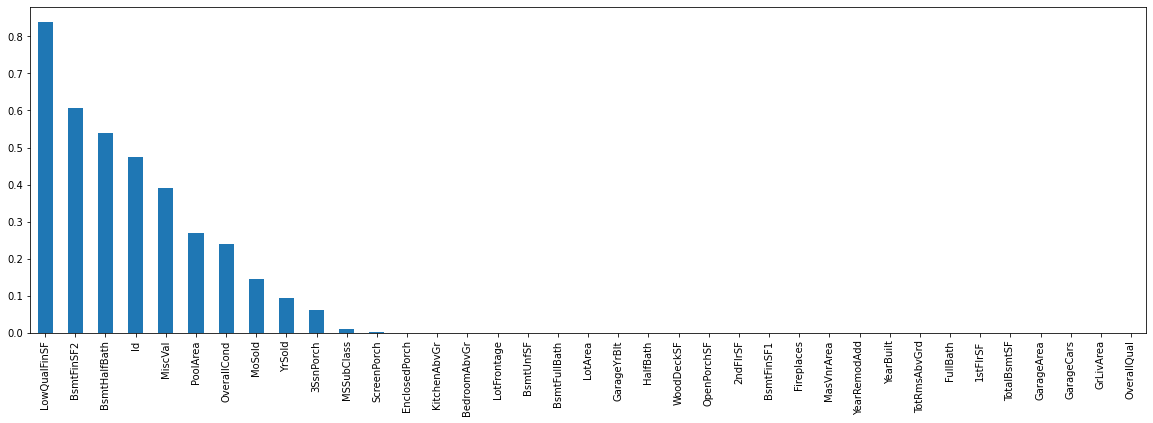

In [ ]:
# univariate anova
univariate = f_regression(X_train.fillna(0), y_train)

# plot values
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=False).plot.bar(figsize=(20,6))

# select features in top 10th percentile
sel_ = SelectPercentile(f_regression,
                        percentile=10).fit(X_train.fillna(0), y_train)

# display selected feature names
X_train.columns[sel_.get_support()]

# select features / discard unwanted features

X_train = sel_.transform(X_train.fillna(0))
X_train.shape

### Univariate Performance

This procedure works as follows:

* Train a ML model per every single feature
* Determine the performance of the models
* Select features if model performance is above a certain threshold

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

from feature_engine.selection import SelectBySingleFeaturePerformance

data = pd.read_csv('datasets/dataset_2.csv')
data.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

# set up a machine learning model
rf = RandomForestClassifier(
    n_estimators=10, random_state=1, n_jobs=4)

# set up the selector
sel = SelectBySingleFeaturePerformance(
    variables=None,
    estimator=rf,
    scoring="roc_auc",
    cv=3,
    threshold=0.5)

# find predictive features
sel.fit(X_train, y_train)

SelectBySingleFeaturePerformance(cv=3,
                                 estimator=RandomForestClassifier(bootstrap=True,
                                                                  ccp_alpha=0.0,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  max_samples=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity_split=None,
                                                                  min_samples_leaf=1,
                   

((35000, 72), (15000, 72))

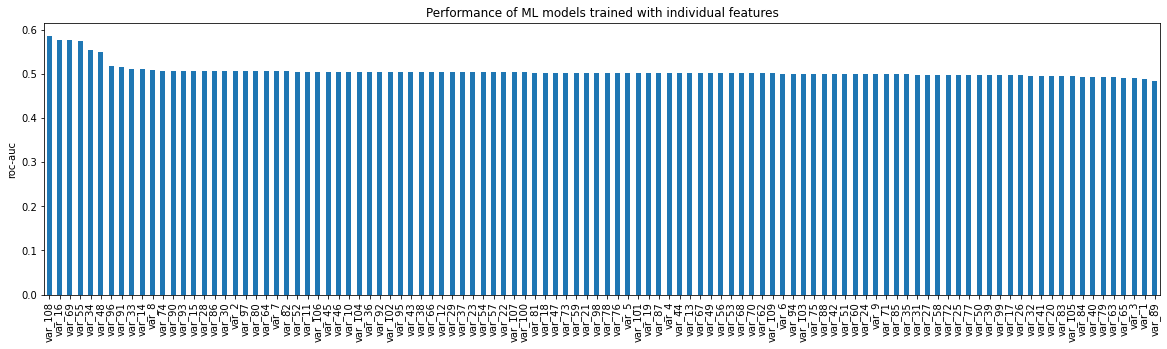

In [ ]:
#  the transformer stores a dictionary of feature:metric pairs
# in this case is the roc_auc of each individual model
sel.feature_performance_

# we can plot feature importance sorted by importance
pd.Series(sel.feature_performance_).sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.title('Performance of ML models trained with individual features')
plt.ylabel('roc-auc')

# the features that will be removed
len(sel.features_to_drop_)

# remove non-prective features
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

### Select with Target Mean as Performance Proxy

This transformer contains the methods of feature selection described in the notebook **06.2-Method-used-in-a-KDD-competition**

The functionality has now been included in Feature-engine.

Feature-engine automatically detects categorical and numerical variables. 

- Categories in categorical variables will be replaced by the mean value of the target.

- Numerical variables will be first discretised and then, each bin replaced by the target mean value.

In [ ]:
# load the titanic dataset

data = pd.read_csv('datasets/titanic.csv')
data.shape

# Variable preprocessing:

# then I will narrow down the different cabins by selecting only the
# first letter, which represents the deck in which the cabin was located

# captures first letter of string (the letter of the cabin)
data['cabin'] = data['cabin'].str[0]

# now we will rename those cabin letters that appear only 1 or 2 in the
# dataset by N

# replace rare cabins by N
data['cabin'] = np.where(data['cabin'].isin(['T', 'G']), 'N', data['cabin'])

data['cabin'].unique()

# cap variable at 3, the rest of the values are
# shown by too few observations
data['parch'] = np.where(data['parch']>3,3,data['parch'])

# cap variable at 3, the rest of the values are
# shown by too few observations
data['sibsp'] = np.where(data['sibsp']>3,3,data['sibsp'])

# cast discrete variables as categorical

# feature-engine considers categorical variables all those of type
# object. So in order to work with numerical variables as if they
# were categorical, we  need to cast them as object
data[['pclass','sibsp','parch']] = data[['pclass','sibsp','parch']].astype('O')

# check absence of missing data
data.isnull().sum()

pclass       0
survived     0
name         0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
cabin        0
embarked     0
boat         0
body         0
home.dest    0
dtype: int64

In [ ]:
from feature_engine.selection import SelectByTargetMeanPerformance
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['survived'], axis=1),
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

# feautre engine automates the selection for both
# categorical and numerical variables

sel = SelectByTargetMeanPerformance(
    variables=None, # automatically finds categorical and numerical variables
    scoring="roc_auc_score", # the metric to evaluate performance
    threshold=0.6, # the threshold for feature selection, 
    bins=3, # the number of intervals to discretise the numerical variables
    strategy="equal_frequency", # whether the intervals should be of equal size or equal number of observations
    cv=2,# cross validation
    random_state=1, #seed for reproducibility
)

sel.fit(X_train, y_train)

# after fitting, we can find the categorical variables
# using this attribute
sel.variables_categorical_

# and here we find the numerical variables
sel.variables_numerical_

# here the selector stores the roc-auc per feature
sel.feature_performance_

# and these are the features that will be dropped
sel.features_to_drop_

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

# Wrapper Methods

In [ ]:
data = pd.read_csv('datasets/houseprice.csv')
data.shape

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 37), (438, 37))

## Step forward

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score

# find and remove correlated features

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

# removed correlated features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

correlated features:  3


In [ ]:
# step forward feature selection

sfs = SFS(RandomForestRegressor(n_estimators=10, n_jobs=4, random_state=10), 
           k_features=20, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=2)

sfs = sfs.fit(np.array(X_train), y_train)

# indices of the selected columns
sfs.k_feature_idx_

# selected columns
X_train.columns[list(sfs.k_feature_idx_)]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   11.4s finished

[2021-06-16 06:18:51] Features: 1/20 -- score: 0.6448864917335086[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    9.4s finished

[2021-06-16 06:19:00] Features: 2/20 -- score: 0.6946490592888616[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    9.0s finished

[2021-06-16 06:19:09] Features: 3/20 -- score: 0.732141233157488[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', '3SsnPorch', 'ScreenPorch', 'PoolArea'],
      dtype='object')

In [ ]:
# Compare performance between all and selected features

# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestRegressor(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict(X_train)
    print('Random Forests roc-auc: {}'.format(r2_score(y_train, pred)))
    
    print('Test set')
    pred = rf.predict(X_test)
    print('Random Forests roc-auc: {}'.format(r2_score(y_test, pred)))

selected_feat = X_train.columns[list(sfs.k_feature_idx_)]

# evaluate performance of algorithm built
# using selected features

print(run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test))

# and for comparison, we train random forests using
# all features (except the correlated ones, which we removed already)
print(run_randomForests(X_train,
                  X_test,
                  y_train, y_test))

Train set
Random Forests roc-auc: 0.8629621682457452
Test set
Random Forests roc-auc: 0.8246015925536159
None
Train set
Random Forests roc-auc: 0.8699152317492538
Test set
Random Forests roc-auc: 0.8190809813112794
None


## Step backward

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score

# find and remove correlated features

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

# removed correlated features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

correlated features:  3


In [ ]:
# step forward feature selection

sfs = SFS(RandomForestRegressor(n_estimators=10, n_jobs=4, random_state=10), 
           k_features=20, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=2)

sfs = sfs.fit(np.array(X_train), y_train)

# indices of the selected columns
sfs.k_feature_idx_

# selected columns
X_train.columns[list(sfs.k_feature_idx_)]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   11.8s finished

[2021-06-16 06:45:32] Features: 33/20 -- score: 0.825434533342885[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   11.3s finished

[2021-06-16 06:45:44] Features: 32/20 -- score: 0.8269182238540728[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   11.1s finished

[2021-06-16 06:45:55] Features: 31/20 -- score: 0.8321203993856869[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

Index(['Id', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea',
       'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal', 'MoSold'],
      dtype='object')

In [ ]:
# Compare performance between all and selected features

# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestRegressor(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict(X_train)
    print('Random Forests roc-auc: {}'.format(r2_score(y_train, pred)))
    
    print('Test set')
    pred = rf.predict(X_test)
    print('Random Forests roc-auc: {}'.format(r2_score(y_test, pred)))

selected_feat = X_train.columns[list(sfs.k_feature_idx_)]

# evaluate performance of algorithm built
# using selected features

print(run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test))

# and for comparison, we train random forests using
# all features (except the correlated ones, which we removed already)
print(run_randomForests(X_train,
                  X_test,
                  y_train, y_test))

Train set
Random Forests roc-auc: 0.8702345974928545
Test set
Random Forests roc-auc: 0.8240294353877188
None
Train set
Random Forests roc-auc: 0.8699152317492538
Test set
Random Forests roc-auc: 0.8190809813112794
None


## Exhaustive Feature Search

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score

# find and remove correlated features

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

# removed correlated features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

correlated features:  3


In [ ]:
# step forward feature selection

efs = EFS(RandomForestRegressor(), 
          min_features=1,
          max_features=2,
          scoring='r2',
          print_progress=True,
           cv=2)

efs = efs.fit(np.array(X_train), y_train)

# indices of the selected columns
efs.best_idx_

# selected columns
X_train.columns[list(efs.best_idx_)]

Features: 595/595

Index(['OverallQual', 'GarageCars'], dtype='object')

In [ ]:
# Compare performance between all and selected features

# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestRegressor(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict(X_train)
    print('Random Forests roc-auc: {}'.format(r2_score(y_train, pred)))
    
    print('Test set')
    pred = rf.predict(X_test)
    print('Random Forests roc-auc: {}'.format(r2_score(y_test, pred)))

selected_feat = X_train.columns[list(efs.best_idx_)]

# evaluate performance of algorithm built
# using selected features

print(run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test))

# and for comparison, we train random forests using
# all features (except the correlated ones, which we removed already)
print(run_randomForests(X_train,
                  X_test,
                  y_train, y_test))

Train set
Random Forests roc-auc: 0.7358029283039249
Test set
Random Forests roc-auc: 0.7363162876279004
None
Train set
Random Forests roc-auc: 0.8699152317492538
Test set
Random Forests roc-auc: 0.8190809813112794
None


# Embedded Methods

## Linear Models

In [ ]:
# For classification: https://colab.research.google.com/drive/153bfmIzvUE9QopAWDEzA-7oCA3RqLLLZ#scrollTo=o_Bb-LTy3NgS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel

data = pd.read_csv('datasets/houseprice.csv')
data.shape

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 37), (438, 37))

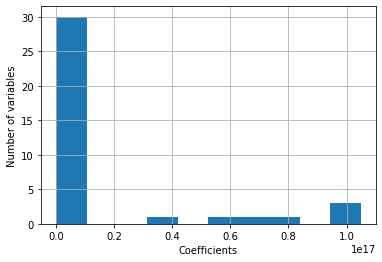

total features: 37
selected features: 7
features with coefficients greater than the mean coefficient: 7


In [ ]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# the features in the house dataset are in different scales
# so we train a scaler to scale them

scaler = StandardScaler()
scaler.fit(X_train)

# we train a Linear regression model and select
# features with higher coefficients.

# the LinearRegression object from sklearn is a non-regularised
# linear method. It fits by matrix multiplication and not 
# gradient descent.

# therefore we don't need to specify penalty and other parameters

sel_ = SelectFromModel(LinearRegression())

sel_.fit(scaler.transform(X_train), y_train)

# let's count the number of variables selected
selected_feat = X_train.columns[(sel_.get_support())]

len(selected_feat)

# and now let's plot the histogram of absolute coefficients

pd.Series(np.abs(sel_.estimator_.coef_).ravel()).hist(bins=10)
plt.xlabel('Coefficients')
plt.ylabel('Number of variables')
plt.show()

# and now, let's compare the  amount of selected features
# with the amount of features which coefficient is above the
# mean coefficient, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_feat)))

print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(
            np.abs(sel_.estimator_.coef_) > np.abs(
                sel_.estimator_.coef_).mean())))

## Lasso

In [ ]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

# For classification: https://colab.research.google.com/drive/153bfmIzvUE9QopAWDEzA-7oCA3RqLLLZ#scrollTo=o_Bb-LTy3NgS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel

data = pd.read_csv('datasets/houseprice.csv')
data.shape

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 37), (438, 37))

In [ ]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# the features in the house dataset are in different scales
# so we train a scaler to scale them

scaler = StandardScaler()
scaler.fit(X_train)

# here, again I will train a Lasso Linear regression and select
# the non zero features in one line.

# bear in mind that the linear regression object from sklearn does
# not allow for regularisation. So If you want to make a regularised
# linear regression you need to import specifically "Lasso"

# alpha is the penalisation, so I set it high
# to force the algorithm to shrink some coefficients

sel_ = SelectFromModel(Lasso(alpha=100, random_state=10))
sel_.fit(scaler.transform(X_train), y_train)

sel_.get_support()

# make a list with the selected features and print the outputs
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 37
selected features: 33
features with coefficients shrank to zero: 4


## Trees

In [ ]:
# load dataset
data = pd.read_csv('datasets/dataset_2.csv')
data.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

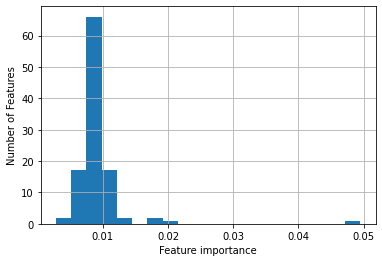

total features: 108
selected features: 37
features with importance greater than the mean importance of all features: 37


In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# we fit Random Forests and select features in 2 lines of code

# first I specify the Random Forest instance and its parameters

# Then I use the selectFromModel class from sklearn
# to automatically select the features

# SelectFrom model will select those features which importance
# is greater than the mean importance of all the features
# by default, but you can alter this threshold if you want to

sel_ = SelectFromModel(RandomForestClassifier(n_estimators=3, random_state=10))

sel_.fit(X_train, y_train)

# this command let's me visualise those features that were selected.

# sklearn will select those features which importance values
# are greater than the mean of all the coefficients.
sel_.get_support()

# let's make a list and count the selected features
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

# and now let's plot the distribution of importances
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

# and now, let's compare the  amount of selected features
# with the amount of features which importance is above the
# mean of all features, to make sure we understand the output of
# SelectFromModel

print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_feat)))

print(
    'features with importance greater than the mean importance of all features: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

In [ ]:
# Recursively Feature Selection using Random Forest (takes a lot of time?)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score

# we do model training and feature selection in 2 lines of code

# first I specify the Random Forest and its parameters

# Then RFE from sklearn to remove features recursively

# RFE will remove one feature at each iteration => the least  important.
# then it will build another random forest and repeat
# till a criteria is met.

# in sklearn the criteria to stop is an arbitrary number
# of features to select, that we need to decide before hand
# not the best solution, but a solution

sel_ = RFE(RandomForestClassifier(n_estimators=10, random_state=10), n_features_to_select=3)
sel_.fit(X_train, y_train)

# selected features

selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

# let's display the list of features
selected_feat

# Hybrid Methods

## Feature Shuffling

In [ ]:
from feature_engine.selection import SelectByShuffling

# load dataset
data = pd.read_csv('datasets/dataset_2.csv')
data.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

train auc score:  0.7010001123593995
test auc score:  0.6953477325844082


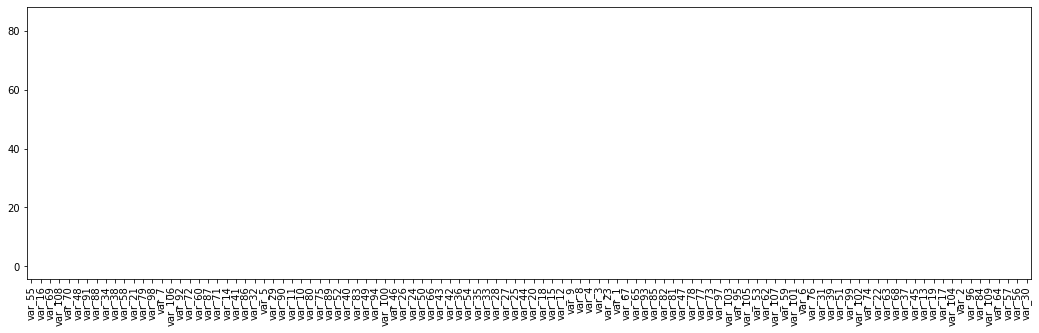

In [ ]:
# We will use Random Forests, but remember that 
# you can use this procedure with any machine learning algorithm

rf = RandomForestClassifier(
    n_estimators=50, max_depth=2, random_state=2909, n_jobs=4)

sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=rf, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=3, # cross validation
    random_state=1 # seed
)

sel.fit(X_train, y_train)

# performance of model trained with all features
sel.initial_model_performance_

# drop in performance caused by shuffling the feature
sel.performance_drifts_

# histogram of the performance drops
pd.Series(sel.performance_drifts_).hist(bins=50)

# bar plot of the performance drops
pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(18,5))

# features that will be removed
len(sel.features_to_drop_)

# remove features
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

# Now let's build a random forests only with the selected features

rf.fit(X_train, y_train)

# print roc-auc in train and testing sets
print(
    'train auc score: ',
    roc_auc_score(y_train, (rf.predict_proba(X_train))[:,1]))
print(
    'test auc score: ',
    roc_auc_score(y_test, (rf.predict_proba(X_test))[:, 1]))

## Recursive Feature Elimination

In [ ]:
# load dataset
data = pd.read_csv('datasets/dataset_1.csv')
data.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 300), (15000, 300))

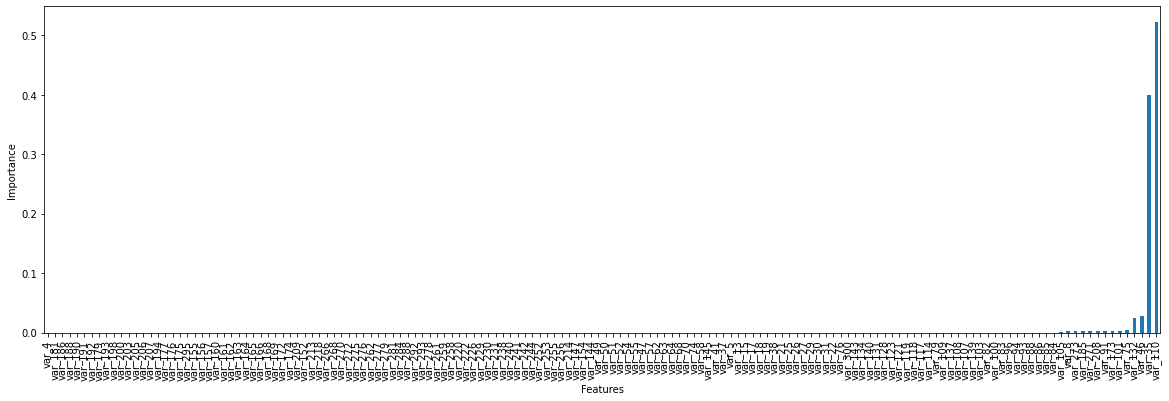

((35000, 5), (15000, 5))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline

from feature_engine.selection import (
    RecursiveFeatureElimination,
    DropConstantFeatures,
    DropDuplicateFeatures,
)

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train)

# remove features

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.shape, X_test.shape

# the ML model for which we want to select features
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

# Setup the RFE selector
sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = 'roc_auc', # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=2, # cross-validation
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train, y_train)

# performance of model trained using all features
sel.initial_model_performance_

# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Number of features that will be removed
len(sel.features_to_drop_)

# select features
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

## Recursive Feature Addition

In [ ]:
# load dataset
data = pd.read_csv('datasets/dataset_1.csv')
data.shape

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 300), (15000, 300))

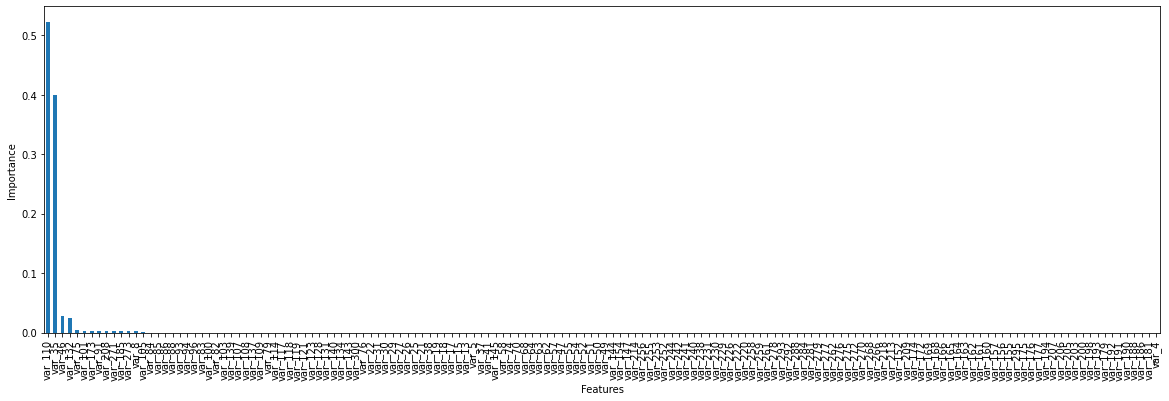

Test selected features ROC AUC=0.802329


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline

from feature_engine.selection import (
    RecursiveFeatureAddition,
    DropConstantFeatures,
    DropDuplicateFeatures,
)

# remove constant, quasi-constant and duplicated
# to speed things up

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train)

# remove features

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.shape, X_test.shape

# the ML model for which we want to select features
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

# Setup the RFA selector
rfa = RecursiveFeatureAddition(
    variables=None,  # automatically evaluate all numerical variables
    estimator=model,  # the ML model
    scoring='roc_auc',  # the metric we want to evalute
    threshold=0.0001,  # the minimum performance increase needed to select a feature
    cv=2,  # cross-validation
)

rfa.fit(X_train, y_train)

# performance of model trained using all features
rfa.initial_model_performance_

# importance of all features based of initial model
rfa.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Number of features that will be removed
len(rfa.features_to_drop_)

# select features
X_train = rfa.transform(X_train)
X_test = rfa.transform(X_test)

# now for comparison, we build a model with the selected features only

model_final = GradientBoostingClassifier(
    n_estimators=10, max_depth=2, random_state=10)

# fit the model with the selected features
model_final.fit(X_train, y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test)[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))